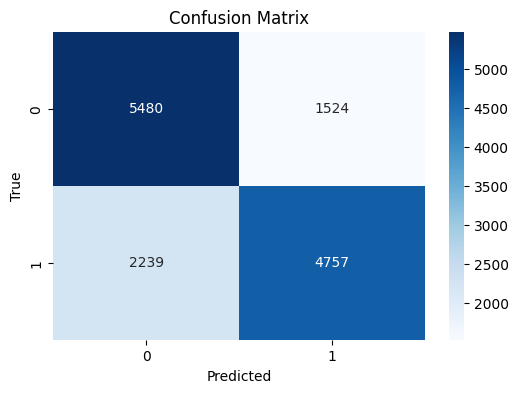

(0.7312142857142857,
 0.7165775401069518,
 cardio
 0    0.5003
 1    0.4997
 Name: proportion, dtype: float64)

In [ ]:
#ここからまともなコードになった
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from fttransformer import FTTransformer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# データの読み込みと前処理
data = pd.read_csv("/home/osajima/ドキュメント/program/Transformer_Study/fttransformer_pytorch/cardio_train.csv", sep=';')
data = data.drop(columns=["id"])

X = data.drop(columns=["cardio"])
y = data["cardio"]

categorical_cols = ["gender", "cholesterol", "gluc"]
continuous_cols = [col for col in X.columns if col not in categorical_cols]

# ラベルエンコーディング
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# スケーリング（連続値）
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

# クラスバランス確認
class_balance = y.value_counts(normalize=True)

# 学習・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class CardioDataset(Dataset):
    def __init__(self, X, y):
        self.X_categ = torch.tensor(X[categorical_cols].values, dtype=torch.long)
        self.X_cont = torch.tensor(X[continuous_cols].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_categ[idx], self.X_cont[idx], self.y[idx]

train_dataset = CardioDataset(X_train, y_train)
test_dataset = CardioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FTTransformer(
    categories=[X[col].nunique() for col in categorical_cols],
    num_continuous=len(continuous_cols),
    dim=64,
    depth=6,
    heads=8,
    ff_dropout=0.2,
    attn_dropout=0.2
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

# 学習ループ
EPOCHS = 5
train_losses = []
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for x_cat, x_cont, labels in train_loader:
        x_cat, x_cont, labels = x_cat.to(device), x_cont.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(x_cat, x_cont)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

# 評価
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x_cat, x_cont, labels in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)
        outputs = model(x_cat, x_cont)
        preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

# 混同行列プロット
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

acc, f1, class_balance
